In [6]:
import itertools
import os
import sys
sys.path.append("/cluster/u/rrastogi/ECNN/X-CAP/src/utils")
from evaluation_utils import *

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

TRAIN_PATH = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/train.features"
D_ORIG_TEST_PATH = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/total_test.features"
D_VAL_TEST_PATH = "/cluster/u/rrastogi/ECNN/results/d_validation/xcap/featurize_0520/total_test.features"

In [7]:
XCAP_MDL_FILE = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl"

baseline_clf = lgb.Booster(model_file=XCAP_MDL_FILE)
no_zygosity_clf = None

In [13]:
def no_zygosity(input_path):
    features, X, Y = get_xcap_data(input_path)
    zyg_index = features.index("zygosity")
    X[:, zyg_index] = 0
    return X, Y

In [11]:
# order parameter values from most regularized to least regularized
hyperparameter_grid = {
    "num_iterations": [100, 500, 1000],
    "min_data_in_leaf": [20, 10, 5, 1],
    "max_depth": [3, 6, 9, 12],
    "num_thread": [6],
    "objective": ["binary"]
}

def get_hyperparameter_permutations():
    keys, values = zip(*hyperparameter_grid.items())
    permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return permutations

def train_classifier(input_filepath, mod_zyg=None):
    hyp_permutations = get_hyperparameter_permutations()
    hyp_scores = [[] for _ in range(len(hyp_permutations))]
    
    assert mod_zyg is None
    X, Y = no_zygosity(input_filepath)
        
    kf = KFold(n_splits=5, shuffle=True)
    for i, (train_index, val_index) in enumerate(kf.split(X), start=1):
        print("On fold {} of cross-validation".format(i))
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        dtrain = lgb.Dataset(X_train, Y_train)
        
        for i, permutation in enumerate(hyp_permutations):
            clf = lgb.train(permutation, dtrain)
            Y_val_pred = clf.predict(X_val)
            fpr, tpr, _ = roc_curve(Y_val, Y_val_pred)
            hsr_auc = getHsrAuc(fpr, tpr)
            hyp_scores[i].append(hsr_auc)
    
    hyp_scores = [np.mean(scores) for scores in hyp_scores]
    best_index = np.argmax(hyp_scores)
    best_hyp = hyp_permutations[best_index]
    
    total_dtrain = lgb.Dataset(X, Y)
    clf = lgb.train(best_hyp, total_dtrain)
    return clf

In [14]:
no_zygosity_clf = train_classifier(TRAIN_PATH)

On fold 1 of cross-validation


/cluster/u/rrastogi/conda/envs/myenv/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


On fold 2 of cross-validation
On fold 3 of cross-validation
On fold 4 of cross-validation
On fold 5 of cross-validation


In [54]:
zygosity_omim_clf = train_classifier(TRAIN_PATH, mod_zyg="omim")

On fold 1 of cross-validation
On fold 2 of cross-validation
On fold 3 of cross-validation
On fold 4 of cross-validation
On fold 5 of cross-validation


In [55]:
zygosity_hybrid_clf = train_classifier(TRAIN_PATH, mod_zyg="hybrid")

On fold 1 of cross-validation
On fold 2 of cross-validation
On fold 3 of cross-validation
On fold 4 of cross-validation
On fold 5 of cross-validation


In [19]:
def plotRoc(original_dataset=True, hsr=False):
    plt.figure(figsize=(6, 5), dpi=300)
    legend = []

    # Default XCAP
    test_path = D_ORIG_TEST_PATH if original_dataset else D_VAL_TEST_PATH
    xcap_labels, xcap_preds = get_xcap_predictions(baseline_clf, test_path)
    xcap_fpr, xcap_tpr, _ = roc_curve(xcap_labels, xcap_preds)
    xcap_auroc = auc(xcap_fpr, xcap_tpr) if not hsr else getHsrAuc(xcap_fpr, xcap_tpr)
    plt.plot(xcap_fpr, xcap_tpr)
    legend.append("X-CAP (original): {:.3f}".format(round(xcap_auroc, 3)))
    
    # No zygosity
    X, Y = no_zygosity(test_path)
    Y_pred = no_zygosity_clf.predict(X)
    xcap_fpr, xcap_tpr, _ = roc_curve(Y, Y_pred)
    xcap_auroc = auc(xcap_fpr, xcap_tpr) if not hsr else getHsrAuc(xcap_fpr, xcap_tpr)
    plt.plot(xcap_fpr, xcap_tpr)
    legend.append("X-CAP (no zygosity feature): {:.3f}".format(round(xcap_auroc, 3)))
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0] if not hsr else [0.95, 1.0])
    metric = "ROC" if not hsr else "hsr-ROC"
    dataset = "$D_{original}$" if original_dataset else "$D_{validation}$"
    plt.title("{} ({})".format(metric, dataset))
    plt.legend(legend, loc="upper left" if hsr else "lower right")
    plt.show()

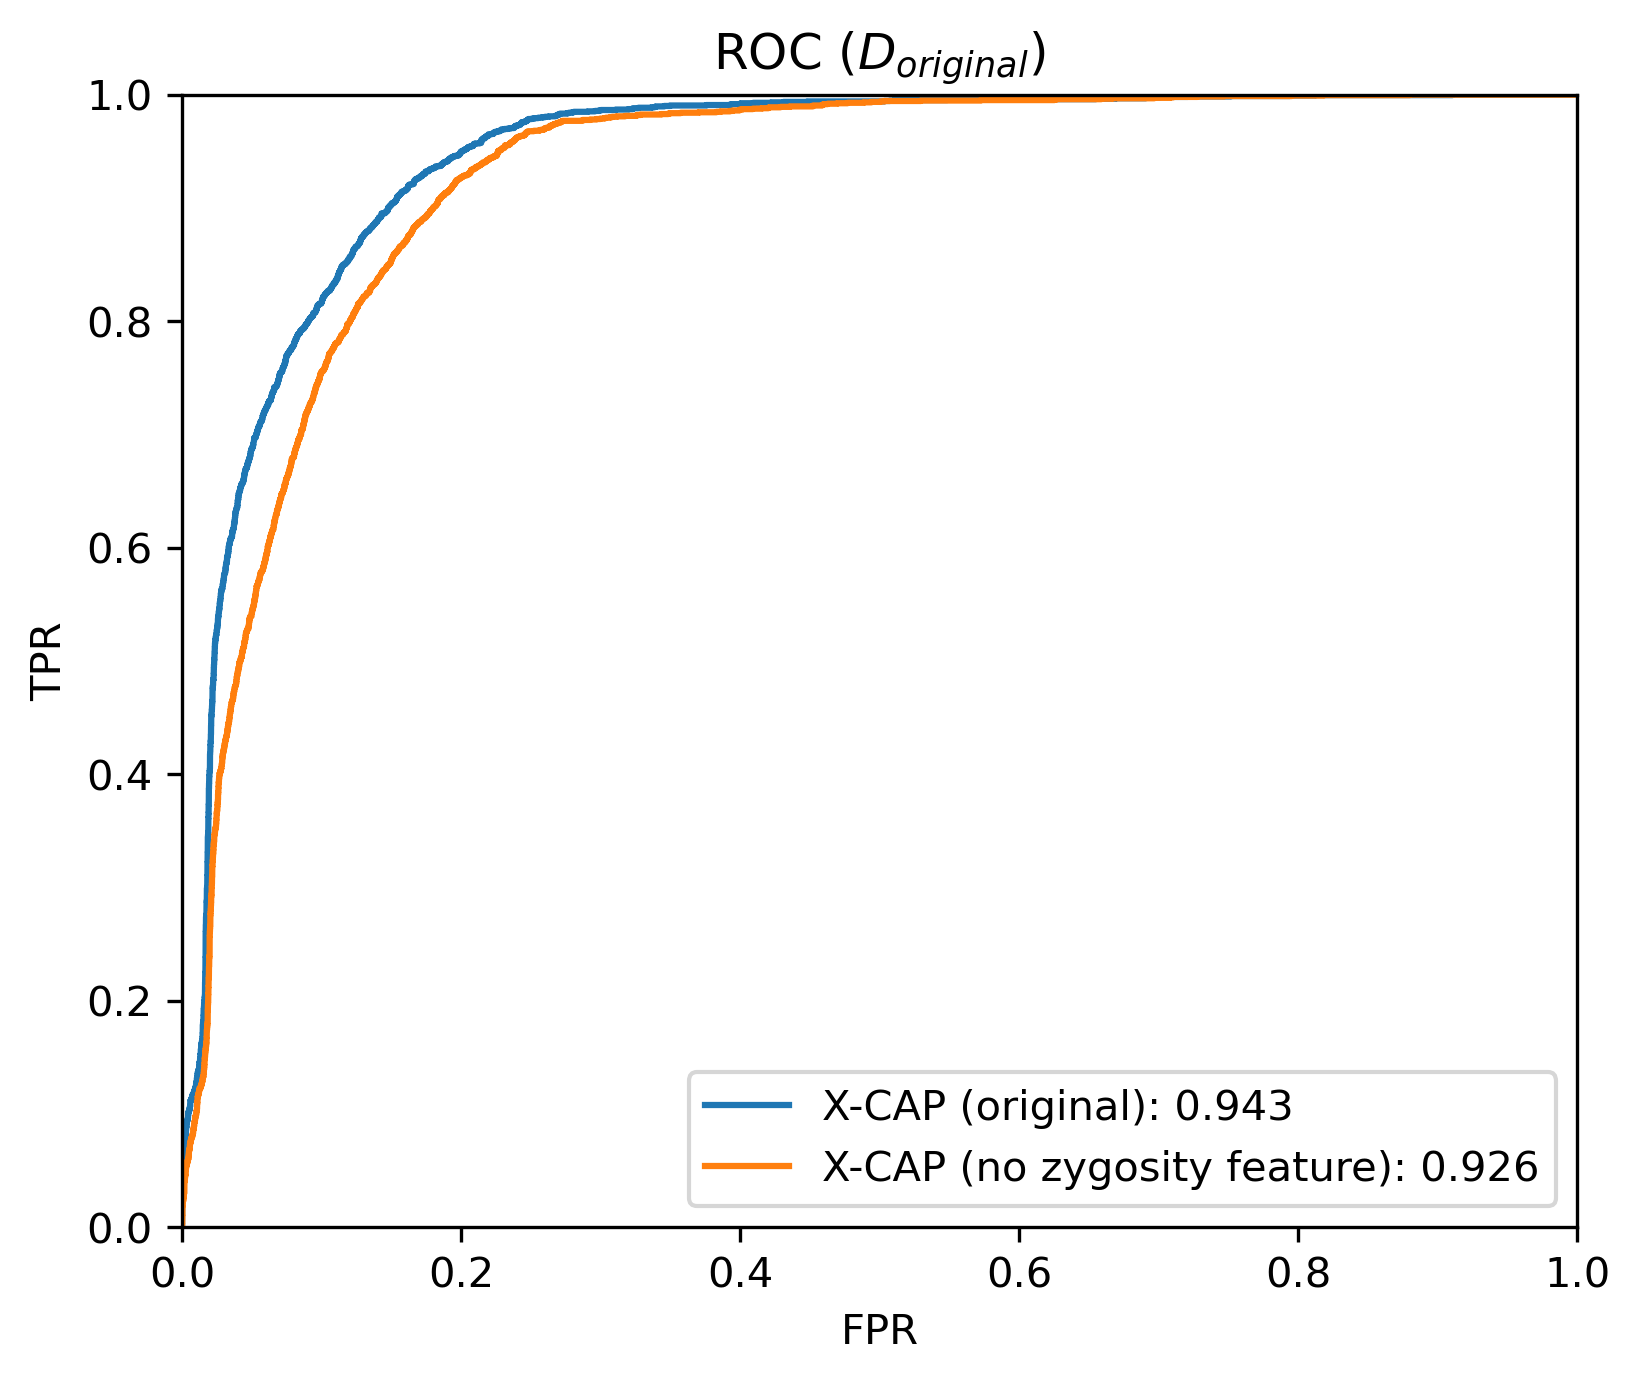

In [20]:
plotRoc()

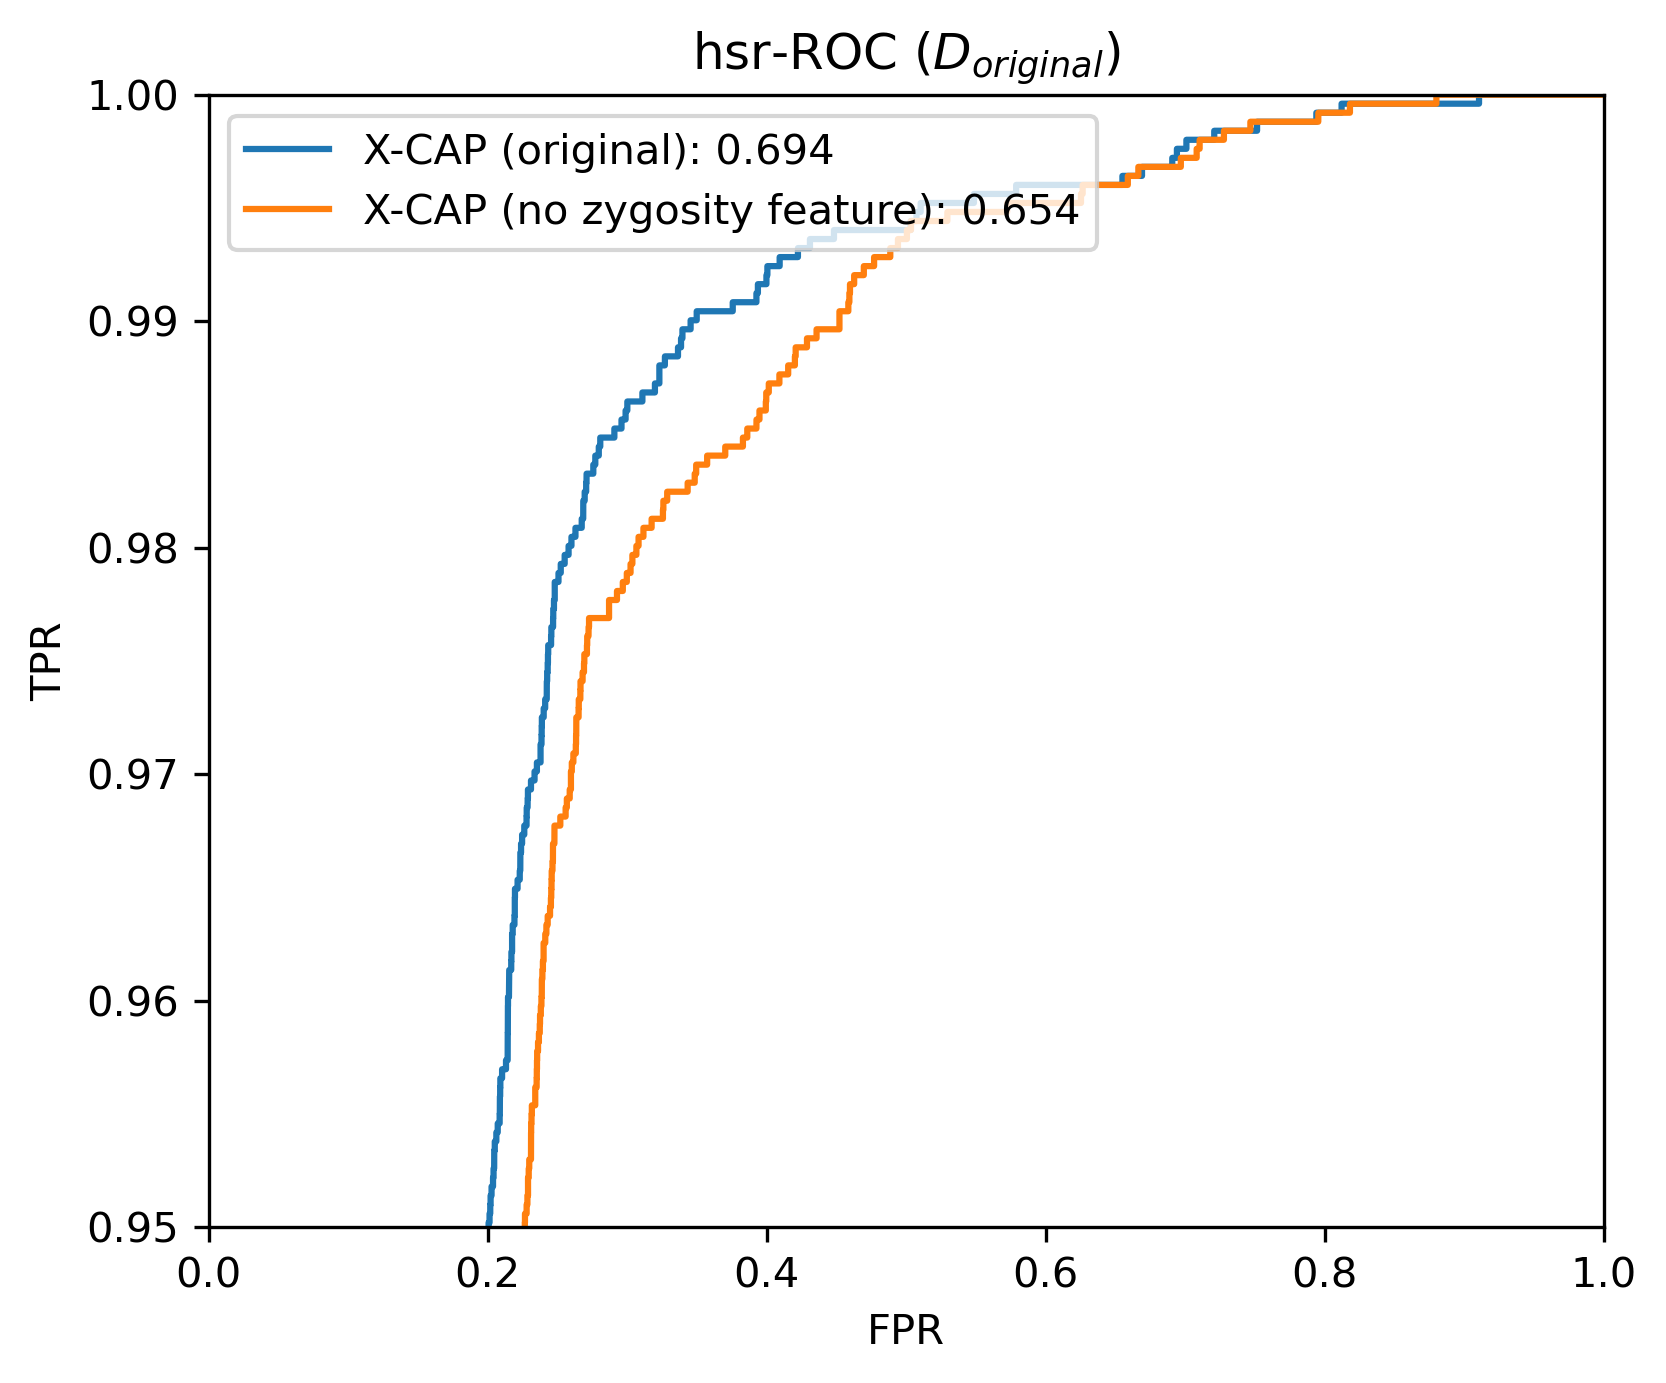

In [21]:
plotRoc(hsr=True)